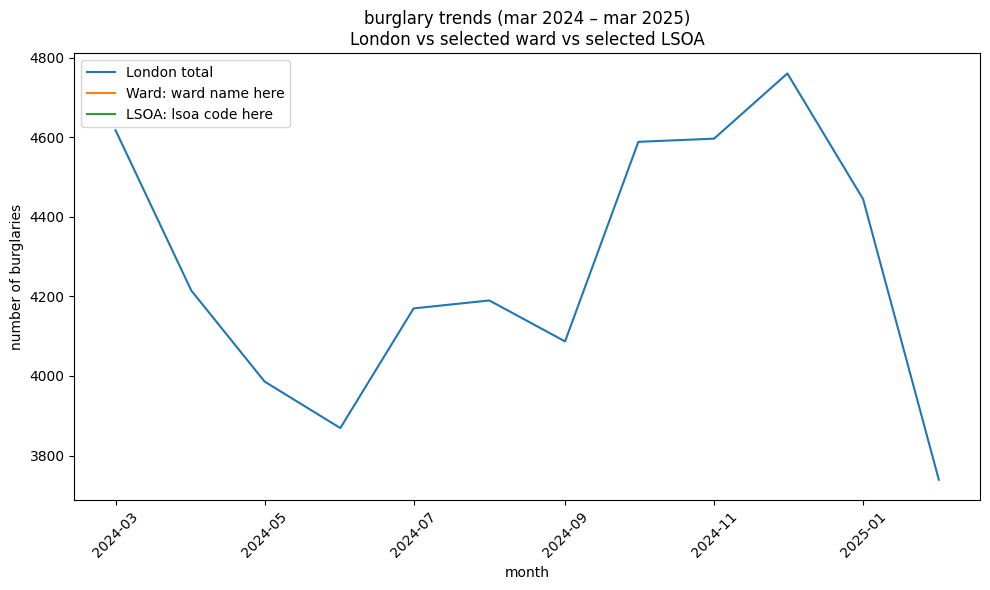

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df = pd.read_csv("all_crimes_2022-2025.csv", parse_dates=["Month"])

# ward_lookup = pd.read_csv("LSOA to Ward.csv")
# ward_lookup = ward_lookup.rename(columns={
#     "LSOA21CD": "LSOA code",  
#     "WD24NM":   "Ward"        
# })
# df = df.merge(ward_lookup[["LSOA code", "Ward"]], on="LSOA code", how="left")

# df_burglary = df[df["Crime type"] == "Burglary"].copy()

# selected_ward = "ward name here"  
# selected_lsoa = "lsoa code here"   

# monthly_london = df_burglary.groupby("Month").size()

# monthly_ward = (
#     df_burglary[df_burglary["Ward"] == selected_ward]
#     .groupby("Month")
#     .size()
# )

# monthly_lsoa = (
#     df_burglary[df_burglary["LSOA code"] == selected_lsoa]
#     .groupby("Month")
#     .size()
# )

# start = pd.Timestamp("2024-03") # most recent
# end   = pd.Timestamp("2025-03")

# monthly_london = monthly_london.loc[start:end]
# monthly_ward   = monthly_ward.loc[start:end]
# monthly_lsoa   = monthly_lsoa.loc[start:end]

# # 5. Plot the three lines
# plt.figure(figsize=(10, 6))
# plt.plot(monthly_london.index, monthly_london.values, label="London total")
# plt.plot(monthly_ward.index,   monthly_ward.values,   label=f"Ward: {selected_ward}")
# plt.plot(monthly_lsoa.index,   monthly_lsoa.values,   label=f"LSOA: {selected_lsoa}")

# plt.xlabel("month")
# plt.ylabel("number of burglaries")
# plt.title("burglary trends (mar 2024 – mar 2025)\nLondon vs selected ward vs selected LSOA")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# 0 data 
df = pd.read_csv("all_crimes_2022-2025.csv", parse_dates=["Month"])  # crime data
lookup = pd.read_csv("lsoa_to_ward.csv")                             # LSOA to ward

df = df.merge(                                                       # add ward to the dataset (WD23NM)
    lookup[["LSOA21CD", "WD23NM"]],
    left_on="LSOA code",      
    right_on="LSOA21CD",       
    how="left"
).rename(columns={"WD23NM": "Ward"})

In [ ]:
# 1. convert months to period so we can calculate year-on-year
df['Month'] = df['Month'].dt.to_period('M')

# 2. filter burglary only
df_burglary = df[df["Crime type"] == "Burglary"].copy()

# 3. the most recent moth in the burglary data
max_period = df_burglary['Month'].max()    
end_period = max_period - 3     # exclude  3 most recent months

# 4. the same month exactly one year earlier
start_period = end_period - 12  # subtract 12 months

# 5. split the burglary data to only take last 13 calculated periods (it's inclusive)
last_year_burglary = df_burglary[
    (df_burglary['Month'] >= start_period) &
    (df_burglary['Month'] <= end_period)].reset_index(drop=True)

# 6. results
print(f"excluded to: {max_period}")
print(f"includes data from: {start_period} - {end_period}")
print("period:", sorted(last_year_burglary['Month'].unique()))

# last_year_burglary : burglary-only data for the most recent year


## start graph from 0 


excluded to: 2025-02
includes data from: 2023-11 - 2024-11
period: [Period('2023-11', 'M'), Period('2023-12', 'M'), Period('2024-01', 'M'), Period('2024-02', 'M'), Period('2024-03', 'M'), Period('2024-04', 'M'), Period('2024-05', 'M'), Period('2024-06', 'M'), Period('2024-07', 'M'), Period('2024-08', 'M'), Period('2024-09', 'M'), Period('2024-10', 'M'), Period('2024-11', 'M')]


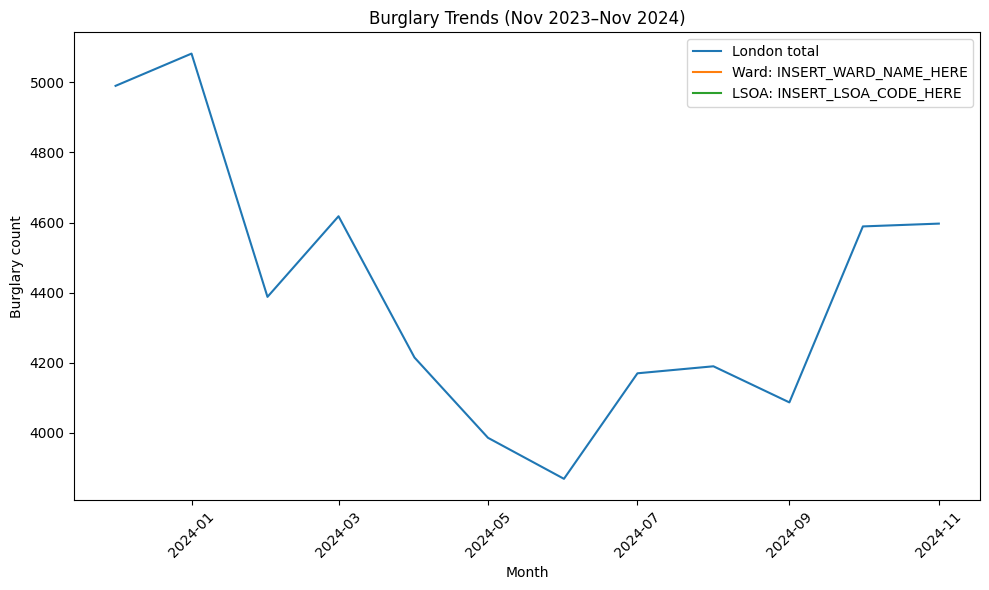

In [ ]:
monthly_all = df_window.groupby("Month").size()

selected_ward = "INSERT_WARD_NAME_HERE" 
selected_lsoa = "INSERT_LSOA_CODE_HERE"  

monthly_ward = (
    df_window[df_window["Ward"] == selected_ward]
    .groupby("Month").size()
)

monthly_lsoa = (
    df_window[df_window["LSOA code"] == selected_lsoa]
    .groupby("Month").size()
)

plt.figure(figsize=(10,6))
plt.plot(monthly_all.index.to_timestamp(), monthly_all.values, label="London total")
plt.plot(monthly_ward.index.to_timestamp(), monthly_ward.values, label=f"Ward: {selected_ward}")
plt.plot(monthly_lsoa.index.to_timestamp(), monthly_lsoa.values, label=f"LSOA: {selected_lsoa}")

plt.xlabel("Month")
plt.ylabel("Burglary count")
plt.title(f"Burglary Trends ({(start_period).to_timestamp():%b %Y}–{end_period.to_timestamp():%b %Y})")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

@st.cache_data
def load_data():
    # 1. Load main crime data
    df = pd.read_csv("all_crimes_2022-2025.csv", parse_dates=["Month"])
    # 2. Load LSOA→Ward lookup
    lookup = pd.read_csv("lsoa_to_ward.csv")
    lookup = lookup.rename(columns={"LSOA21CD": "LSOA code", "WD23NM": "Ward"})
    # 3. Merge, filter burglary, convert Month → Period
    df = df.merge(lookup[["LSOA code","Ward"]], on="LSOA code", how="left")
    df = df[df["Crime type"] == "Burglary"].copy()
    df["Month"] = df["Month"].dt.to_period("M")
    return df

df = load_data()

# Exclude last 3 months, then take 12 months before that
latest = df["Month"].max()
end_period = latest - 3
start_period = end_period - 12
df_window = df[(df["Month"] > start_period) & (df["Month"] <= end_period)]

# Sidebar selections
st.sidebar.header("Select Geography")
ward_list = ["All London"] + sorted(df_window["Ward"].dropna().unique())
lsoa_list = sorted(df_window["LSOA code"].unique())
sel_ward = st.sidebar.selectbox("Ward", ward_list, index=0)
sel_lsoa = st.sidebar.selectbox("LSOA", lsoa_list, index=0)

# Prepare series
monthly_all = df_window.groupby("Month").size()

if sel_ward == "All London":
    monthly_ward = monthly_all
else:
    monthly_ward = df_window[df_window["Ward"] == sel_ward].groupby("Month").size()

monthly_lsoa = df_window[df_window["LSOA code"] == sel_lsoa].groupby("Month").size()

# Convert PeriodIndex to timestamps for plotting
idx = monthly_all.index.to_timestamp()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(idx, monthly_all.values, label="London total")
if sel_ward != "All London":
    ax.plot(idx, monthly_ward.reindex(monthly_all.index, fill_value=0), label=f"Ward: {sel_ward}")
ax.plot(idx, monthly_lsoa.reindex(monthly_all.index, fill_value=0), label=f"LSOA: {sel_lsoa}")

ax.set_title(f"Burglary Trends ({start_period+1} to {end_period})")
ax.set_xlabel("Month")
ax.set_ylabel("Burglary count")
ax.legend()
plt.xticks(rotation=45)
st.pyplot(fig)


2025-06-10 13:15:14.220 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-10 13:15:14.223 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-10 13:15:14.223 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-10 13:15:14.477 
  command:

    streamlit run c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\edukacja\3rd year\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-10 13:15:14.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-10 13:15:14.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-10 13:15:14.985 Thread 'Thread-9': missing Scri

TypeError: '<' not supported between instances of 'float' and 'str'

In [23]:
%pip install streamlit

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.9 MB 8.4 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.9 MB 7.2 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/9.9 MB 6.4 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.9 MB 5.9 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.9 MB 5.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/9.9 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   --------------------------------------- 731.2/731.2 kB 15.1 MB/s eta 0:00:00
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
   ----------


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
